In [1]:
import torch
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from torchsummary import summary

from Transformer.std import MultiHeadAttention

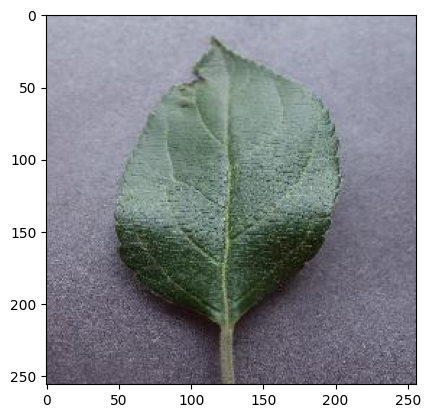

In [2]:
img = Image.open('./test.jpg')
fig = plt.figure()
plt.imshow(img)

In [3]:
# resize to ImageNet size
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)  # 主要是为了添加batch这个维度
x.shape

torch.Size([1, 3, 224, 224])

### Patches Embeddings

In [4]:
patch_size = 16  # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
pathes.shape

torch.Size([1, 196, 768])

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # 使用一个卷积层而不是一个线性层 -> 性能增加
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        # 位置编码信息，一共有(img_size // patch_size)**2 + 1(cls token)个位置向量
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # 将cls token在维度1扩展到输入上
        x = torch.cat([cls_tokens, x], dim=1)
        # 添加位置编码
        print(x.shape, self.positions.shape)
        x += self.positions
        return x

In [6]:
PatchEmbedding()(x).shape

torch.Size([1, 197, 768]) torch.Size([197, 768])


torch.Size([1, 197, 768])

### MLP

In [7]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

### Transformer Encoder

和原始Transformer中的Encoder有所区别：先ln后attention

In [8]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 num_heads: int = 8,
                 dropout: float = 0.,
                 **kwargs):
        super().__init__()

        self.attn_norm = nn.LayerNorm(emb_size)

        self.attention = MultiHeadAttention(
            key_size=emb_size,
            query_size=emb_size,
            value_size=emb_size,
            num_hiddens=emb_size,
            num_heads=num_heads,
            dropout=dropout
        )
        self.attn_dropout = nn.Dropout(drop_p)

        self.ffn_norm = nn.LayerNorm(emb_size)
        self.ffn = FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p)
        self.ffn_dropout = nn.Dropout(drop_p)

    def forward(self, X, valid_lens=None):
        norm_x = self.attn_norm(X)
        Y = X + self.attn_dropout(self.attention(norm_x, norm_x, norm_x, valid_lens))
        # 前馈子层
        norm_y = self.ffn_norm(Y)
        Y = Y + self.ffn_dropout(self.ffn(norm_y))

        return Y

In [9]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768]) torch.Size([197, 768])


torch.Size([1, 197, 768])

### Transformer Encoder

In [10]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [11]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoder()(patches_embedded).shape

torch.Size([1, 197, 768]) torch.Size([197, 768])


torch.Size([1, 197, 768])

### MLP Head

使用 **[CLS] token**，提取第一个 token

In [12]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__()
        self.norm = nn.LayerNorm(emb_size)
        self.fc = nn.Linear(emb_size, n_classes)

    def forward(self, x):
        cls_token = x[:, 0]  # x.shape: (B, N, D)
        return self.fc(self.norm(cls_token))


In [13]:
class ViT(nn.Sequential):
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 emb_size: int = 768,
                 img_size: int = 224,
                 depth: int = 12,
                 n_classes: int = 1000,
                 **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [14]:
model = ViT()
# summary可以打印网络结构和参数
summary(model, input_size=[(3, 224, 224)], batch_size=1, device="cpu")

torch.Size([2, 197, 768]) torch.Size([197, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 768, 14, 14]         590,592
         Rearrange-2              [1, 196, 768]               0
    PatchEmbedding-3              [1, 197, 768]               0
         LayerNorm-4              [1, 197, 768]           1,536
            Linear-5              [1, 197, 768]         589,824
            Linear-6              [1, 197, 768]         589,824
            Linear-7              [1, 197, 768]         589,824
           Dropout-8              [1, 197, 197]               0
DotProductAttention-9               [1, 197, 96]               0
           Linear-10              [1, 197, 768]         589,824
MultiHeadAttention-11              [1, 197, 768]               0
          Dropout-12              [1, 197, 768]               0
        LayerNorm-13              [1, 197, 768]     